# [GD-6] Word Embedding & Bias
## 임베딩 내 편향성 알아보기: 모든 장르 간 편향성 측정해 보기
### 학습 목표
* 데이터의 편향성에 대한 문제의식을 갖는다.
* 임베딩 모델의 편향성을 체크하는 방법 중 하나인 Word Embedding Association Test (WEAT)를 알아본다.
* WEAT 수식의 의미를 이해하고 이를 구현해본다.
* pre-train된 모델을 불러와서 WEAT score를 구해본다.

### 목차          
#### 1. 들어가며          
  1-1. DTM          
  1-2. TF-IDF          
  1-3. WEAT(Word Embedding Association Test)          
  1-4. WEAT Score 계산식          

#### 2. 프로젝트           
  2-1. 준비 및 설치          
  2-2. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기          
  2-3. 추출된 결과로 embedding model 만들기          
  2-4. target, attribute 단어 셋 만들기          
  2-5. WEAT score 계산과 시각화          

#### 3. 회고
  3-1. 최종 정리          
  3-2. 프로젝트를 진행하면서 알아낸 점, 혹은 아직 모호한 점          
  3-3. 참고사이트          




### 루브릭 평가 기준
|평가문항|상세기준|
|:---|:---|
|1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.|워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.|
|2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.|타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.|
|3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.|전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.|   
<br/>

----


## 1. 들어가며

### 1-1. DTM (Document-Term Matrix, 문서 단어 행렬)
* 다수의 문서에서 등장하는 각 단어들의 빈도를 행렬로 표현한 것
* 각 문서에 대한 BoW를 하나의 행렬로 만든 것으로 생각할 수 있으며, BoW와 다른 표현 방법이 아니라 BoW 표현을 다수의 문서에 대해서 행렬로 표현하고 부르는 용어


### 1-2. TF-IDF(Term Frequency-Inverse Document Frequency, 단어 빈도-역 문서 빈도)
* 단어의 빈도와 역 문서 빈도(문서의 빈도에 특정 식을 취함)를 사용하여 DTM 내의 각 단어들마다 중요한 정도를 가중치로 주는 방법
* 문서의 유사도를 구하는 작업, 검색 시스템에서 검색 결과의 중요도를 정하는 작업, 문서 내에서 특정 단어의 중요도를 구하는 작업 등에 쓰일 수 있음


### 1-3. WEAT(Word Embedding Association Test)
* 임베딩 모델의 편향을 측정하는 방식 중 하나

### 1-4. WEAT Score 계산식
<img src = "https://drive.google.com/uc?id=1Uyc9oj28QokbJlSzM_mDawWdNPIzxxnZ">




## 2. 프로젝트 
### 2-1. 준비 및 설치

#### Google Drive Connect

In [7]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


패키지 설치

In [8]:
!pip install konlpy

### 라이브러리 버전을 확인해 봅니다
사용할 라이브러리 버전을 둘러봅시다.

#### 라이브러리 권장 버전
* konlpy == 0.5.2
* gensim == 4.1.2
* sklearn == 1.0
* seaborn == 0.11.2

In [9]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.6.0
3.6.0
1.0.2
0.11.2


In [10]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [11]:
import os

file_path = '/content/drive/MyDrive/ColabNotebooks/GoingDeeper/GD_6/weat/synopsis.txt'


with open(file_path, 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

### 점수 계산 함수

In [12]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

### WEAT Score 함수

In [13]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev


### 2-2. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기


In [14]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(file_path, 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)


In [16]:
print(len(tokenized))

71156


### 2-3. 추출된 결과로 embedding model 만들기


In [17]:
from gensim.models import Word2Vec

# # tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
# model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
# model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
model.most_similar(positive=['영화'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[('작품', 0.9095625877380371),
 ('다큐멘터리', 0.8650466203689575),
 ('드라마', 0.8257701992988586),
 ('영화로', 0.8172327280044556),
 ('주제', 0.8116244077682495),
 ('편의', 0.80950927734375),
 ('형식', 0.8044781684875488),
 ('코미디', 0.799643874168396),
 ('인터뷰', 0.7960782647132874),
 ('감동', 0.7940760254859924)]

#### Word2Vec 훈련 확인하기

In [18]:
model.wv.most_similar(positive=['사랑'])

[('첫사랑', 0.7185068726539612),
 ('애정', 0.7094748616218567),
 ('행복', 0.7081434726715088),
 ('진심', 0.7066642642021179),
 ('고백', 0.7050427794456482),
 ('연애', 0.6980818510055542),
 ('만남', 0.6973499059677124),
 ('이별', 0.6950281858444214),
 ('가슴', 0.6946638226509094),
 ('우정', 0.6906588077545166)]

In [19]:
model.wv.most_similar(positive=['연극'])

[('영감', 0.9099012613296509),
 ('영화감독', 0.9085037708282471),
 ('시나리오', 0.8975505828857422),
 ('데뷔', 0.8887429237365723),
 ('각색', 0.8876742124557495),
 ('영화로', 0.8820352554321289),
 ('대본', 0.8818953037261963),
 ('배우', 0.8773338794708252),
 ('예술가', 0.8731344938278198),
 ('출연', 0.8696432113647461)]


### 2-4. target, attribute 단어 셋 만들기
이전 스텝에서는 TF-IDF를 사용해서 단어 셋을 만들었습니다. 이 방법으로도 어느 정도는 대표 단어를 잘 선정할 수 있습니다. 그러나 TF-IDF가 높은 단어를 골랐음에도 불구하고 중복되는 단어가 발생하는 문제가 있었습니다. 개념축을 표현하는 단어가 제대로 선정되지 않은 것은 WEAT 계산 결과에 악영향을 미칩니다.

TF-IDF를 적용했을 때의 문제점이 무엇인지 지적 가능하다면 그 문제점을 지적하고 스스로 방법을 개선하여 대표 단어 셋을 구축해 보기 바랍니다. TF-IDF 방식을 쓰더라도 중복된 단어를 잘 제거하면 여전히 유용한 방식이 될 수 있습니다.

In [20]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

file_dir = '/content/drive/MyDrive/ColabNotebooks/GoingDeeper/GD_6/weat/'
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(file_dir + file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)


In [21]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


#### TF-IDF 방식 사용해서 단어 셋 만들기


In [22]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [23]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### 두 개념을 대표하는 단어를 TF-IDF가 높은 순으로 추출

In [24]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

#### 상위 100개 단어들 중 중복되는 단어 제외하고 상위 n개 단어 추출

In [25]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### 추출된 단어 살펴보기

In [26]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [27]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


#### 장르별 대표 단어 추출

In [28]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [29]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [30]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [31]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 시작, 위해, 

### 2-5. WEAT score 계산과 시각화
영화 구분, 영화 장르에 따른 편향성을 측정하여 WEAT score로 계산해 보고 이를 Heatmap 형태로 시각화해 봅시다. 편향성이 두드러지는 영화장르 attribute 구성에는 어떤 케이스가 있는지 시각적으로 두드러지게 구성되면 좋습니다.


* Target : 영화 구분
  * 예술영화
  * 일반영화(상업영화)
  
* Attribute : 장르 구분
  * 영화 모든 장르


#### Matrix 채우기

In [32]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [33]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)


#### WEAT Score 값 살펴보기

In [34]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.4873303
SF 공연 -0.3841
SF 공포(호러) -0.66366357
SF 기타 0.35981706
SF 다큐멘터리 0.59301364
SF 드라마 -0.3774502
SF 멜로로맨스 -0.79582375
SF 뮤지컬 0.33297488
SF 미스터리 -0.68075025
SF 범죄 -0.21223049
SF 사극 -0.79990983
SF 서부극(웨스턴) -0.3928425
SF 성인물(에로) -0.59777117
SF 스릴러 -0.5158791
SF 애니메이션 0.40085548
SF 액션 -0.41380998
SF 어드벤처 -0.75077116
SF 전쟁 0.26825115
SF 코미디 -0.46583155
SF 판타지 -0.18387017
가족 공연 0.12694238
가족 공포(호러) -0.17859383
가족 기타 0.7544374
가족 다큐멘터리 0.8191743
가족 드라마 0.15689428
가족 멜로로맨스 -0.66350496
가족 뮤지컬 0.6922064
가족 미스터리 -0.32153055
가족 범죄 0.18612653
가족 사극 -0.0974607
가족 서부극(웨스턴) 0.3819496
가족 성인물(에로) -0.3898206
가족 스릴러 -0.1566204
가족 애니메이션 0.8869996
가족 액션 0.12080823
가족 어드벤처 -0.029772578
가족 전쟁 0.6614801
가족 코미디 0.12078726
가족 판타지 0.3920291
공연 공포(호러) -0.22263367
공연 기타 0.9490967
공연 다큐멘터리 0.91187674
공연 드라마 0.032071594
공연 멜로로맨스 -0.7277308
공연 뮤지컬 0.88161105
공연 미스터리 -0.33984515
공연 범죄 0.10445554
공연 사극 -0.30076253
공연 서부극(웨스턴) 0.112380475
공연 성인물(에로) -0.5247986
공연 스릴러 -0.19912015
공연 애니메이션 0.9404826
공연 액션 0.0267

#### Heatmap 으로 시각화

In [35]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


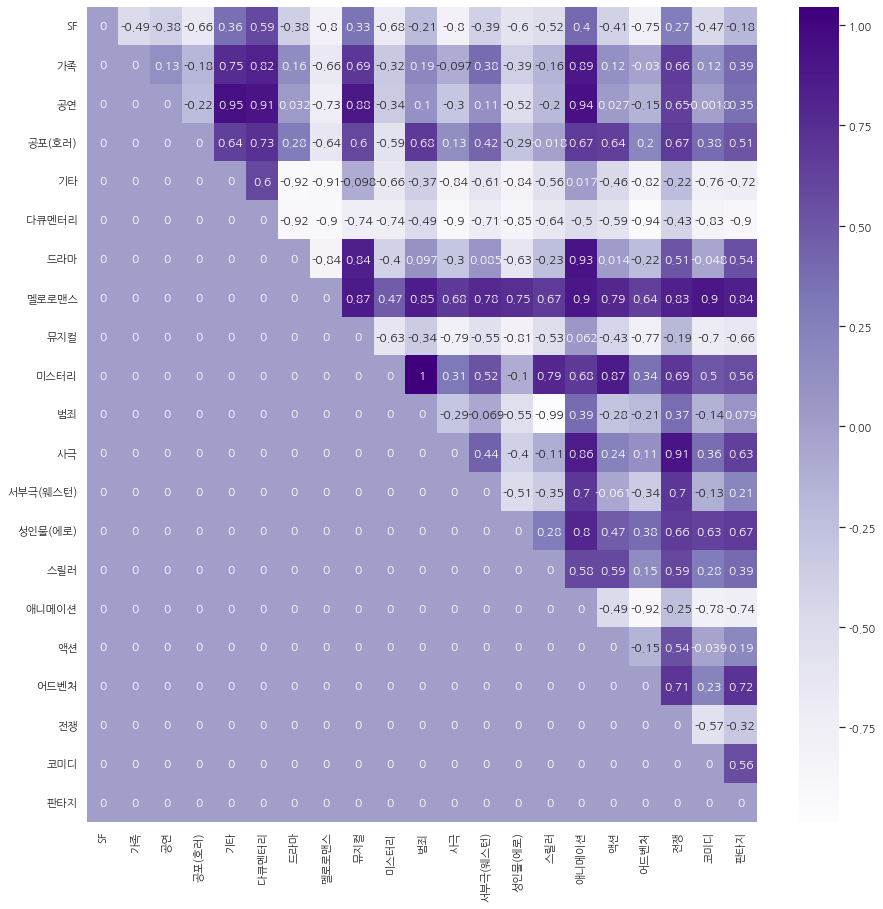

In [37]:

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize = (15, 15))
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='Purples')
ax

## 3. 회고

### 3-1. 최종 정리
* 예술영화와 일반영화, 그리고 모든 장르별로 편향성을 측정하고 시각화하였다. 
* WEAT Score 값이 양수이면 target_X 가 Attribute B 보다 Attribute A 에 더 가까운 것을 의미
  * 공연 뮤지컬 0.8769032 편향성 값을 해석하면 그 값이 양수이기 때문에 target_X: 예술영화가 뮤지컬(Attribute B)보다는 공연(A)에 더 가까운 것을 의미한다.
* WEAT Score 값이 음수이면 target_Y 가 Attribute B 와 더 가까운 것을 의미
  * 범죄 스릴러 -0.9887893 편향성 값을 해석하면 그 값이 음수이기 때문에 target_Y: 일반영화가 스릴러(B)와 더 가까운 것을 의미

<br/>
<br/>

### 3-2. 프로젝트를 진행하면서 알아낸 점, 혹은 아직 모호한 점
* RuntimeWarning: Glyph ____ missing from current font. 경고메시지 나오면서 한글 깨질 때!
  * 런타임 다시 실행 진행해서 해결   
* 아직 WEAT Score 를 명확히 이해하지 못한 것 같다. 더 명확한 해석을 할 수 있도록 좀 더 공부해야겠다.  
<br/>
<br/>


### 3-3. 참고사이트
* DTM, TF-IDF  
  https://wikidocs.net/24559           

* Text Embedding Models Contain Bias. Here's Why That Matters.       
  https://developers.googleblog.com/2018/04/text-embedding-models-contain-bias.html.       

* Semantics derived automatically from language corpora contain human-like biases              
  https://arxiv.org/pdf/1608.07187.pdf             

* 파일 읽기       
  https://itstory1592.tistory.com/27        
        
  
* matplotlib의 구조와 rcParams에 대해 알면 나도 plot 고수   
  https://jrc-park.tistory.com/274      


* Seaborn 히트 맵 크기 설정           
  https://www.delftstack.com/ko/howto/seaborn/size-of-seaborn-heatmap/            

* [Python] 코랩(Colab) 한글 깨짐 현상   
  https://wooono.tistory.com/357                 
  
* Matplotlib cannot find basic fonts         
  https://stackoverflow.com/questions/42097053/matplotlib-cannot-find-basic-fonts/49634918#49634918            
  
* Choosing Colormaps in Matplotlib     
  https://matplotlib.org/stable/tutorials/colors/colormaps.html  
      